In [ ]:
# !pip install hashlib
# !pip install requests

In [69]:
import os
import time
import requests
import io
import shutil
import pandas as pd
from PIL import Image
import selenium
from selenium import webdriver
import hashlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy import ndimage

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Dropout, Input
from keras.callbacks import ModelCheckpoint

from keras import backend as K

import matplotlib.image as mpimg


## Download Left and Right images from the NounProject 

## Organize where the images are stored for splitting purposes.

In [2]:
images_right_dir = 'images/right_arrow/'
images_left_dir = 'images/left_arrow/'
new_dir = 'split/'

In [3]:
images_right = [file for file in os.listdir(images_right_dir) if file.endswith('.png')]

In [4]:
images_right[0:10]

['000273ee5d.png',
 '0012ef1aba.png',
 '008aca9269.png',
 '011791b519.png',
 '0127a213d4.png',
 '01945daea4.png',
 '01ed679155.png',
 '021e7347ff.png',
 '023ea354f5.png',
 '024542b238.png']

In [5]:
print('There are',len(images_right), 'right arrow images')

There are 1064 right arrow images


In [6]:
images_left = [file for file in os.listdir(images_left_dir) if file.endswith('.png')]

In [7]:
print('There are',len(images_left), 'left arrow images')

There are 1015 left arrow images


#### Created Split directory

In [8]:
train_folder = os.path.join(new_dir, 'train')
train_right = os.path.join(train_folder, 'right')
train_left = os.path.join(train_folder, 'left')

test_folder = os.path.join(new_dir, 'test')
test_right = os.path.join(test_folder, 'right')
test_left = os.path.join(test_folder, 'left')

val_folder = os.path.join(new_dir, 'validation')
val_right = os.path.join(val_folder, 'right')
val_left = os.path.join(val_folder, 'left')

In [9]:
# os.mkdir(test_folder)
# os.mkdir(test_right)
# os.mkdir(test_left)

# os.mkdir(train_folder)
# os.mkdir(train_right)
# os.mkdir(train_left)

# os.mkdir(val_folder)
# os.mkdir(val_right)
# os.mkdir(val_left)

In [10]:
# train right
imgs = images_right[:700]
for img in imgs:
    origin = os.path.join(images_right_dir, img)
    destination = os.path.join(train_right, img)
    shutil.copyfile(origin, destination)

# validation right
imgs = images_right[700:900]
for img in imgs:
    origin = os.path.join(images_right_dir, img)
    destination = os.path.join(val_right, img)
    shutil.copyfile(origin, destination)
    
# test right
imgs = images_right[900:]
for img in imgs:
    origin = os.path.join(images_right_dir, img)
    destination = os.path.join(test_right, img)
    shutil.copyfile(origin, destination)    

In [11]:
# train left
imgs = images_left[:700]
for img in imgs:
    origin = os.path.join(images_left_dir, img)
    destination = os.path.join(train_left, img)
    shutil.copyfile(origin, destination)
# validation left
imgs = images_left[700:900]
for img in imgs:
    origin = os.path.join(images_left_dir, img)
    destination = os.path.join(val_left, img)
    shutil.copyfile(origin, destination)
# test left
imgs = images_left[900:]
for img in imgs:
    origin = os.path.join(images_left_dir, img)
    destination = os.path.join(test_left, img)
    shutil.copyfile(origin, destination)

In [12]:
#Removed image array exploration section to EDA_Left_Right_Arrows.ipynb

In [13]:
# get all the data in the directory split/test (280 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_folder, classes =  ['Right', 'Left'],
        color_mode="rgba", target_size=(200, 200), batch_size = 280) 

# get all the data in the directory split/validation (400 images), and reshape them
val_generator = ImageDataGenerator().flow_from_directory(
        val_folder, classes =  ['Right', 'Left'],
        color_mode="rgba", target_size=(200, 200), batch_size = 400)

# get all the data in the directory split/train (1400 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_folder, classes =  ['Right', 'Left'],
        color_mode="rgba", target_size=(200, 200), batch_size=1400)

Found 282 images belonging to 2 classes.
Found 401 images belonging to 2 classes.
Found 1411 images belonging to 2 classes.


In [14]:
# Note that here I'd like to remove the three columns that are unnecerssay, RGB, since the only column with values is the Alpha of RGBA

In [15]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [16]:
# Three nested for loops then delete first 3 elements. Try on the first and proceed from there. 
train_images[0][0][0]

array([0., 0., 0., 0.], dtype=float32)

In [17]:
# # Explore your dataset again
# m_train = train_images.shape[0]
# num_px = train_images.shape[1]
# m_test = test_images.shape[0]
# m_val = val_images.shape[0]

# print ("Number of training samples: " + str(m_train))
# print ("Number of testing samples: " + str(m_test))
# print ("Number of validation samples: " + str(m_val))
# print ("train_images shape: " + str(train_images.shape))
# print ("train_labels shape: " + str(train_labels.shape))
# print ("test_images shape: " + str(test_images.shape))
# print ("test_labels shape: " + str(test_labels.shape))
# print ("val_images shape: " + str(val_images.shape))
# print ("val_labels shape: " + str(val_labels.shape))

In [18]:
# train_img = train_images.reshape(train_images.shape[0], -1)
# train_img = train_images.reshape(train_images.shape[0], -1)
# test_img = test_images.reshape(test_images.shape[0], -1)
# val_img = val_images.reshape(val_images.shape[0], -1)

# print(train_images.shape)
# print(train_img.shape)
# print(test_img.shape)
# print(val_img.shape)

In [19]:
train_y = np.reshape(np.flip(train_labels, axis=1)[:,0], (1400,1))
print(train_labels.shape)
print('train labels final:', np.shape(train_y))
test_y = np.reshape(np.flip(test_labels, axis=1)[:,0], (280,1))
print('test labels final:', np.shape(test_y))
val_y = np.reshape(np.flip(val_labels, axis=1)[:,0], (400,1))
print('test labels final:', np.shape(test_y))
# train_y = train_labels.T[[1]]
# test_y = test_labels.T[[1]]
# val_y = val_labels.T[[1]]

(1400, 2)
train labels final: (1400, 1)
test labels final: (280, 1)
test labels final: (280, 1)


In [20]:
print(train_y.shape)

(1400, 1)


In [21]:
train_generator.class_indices


{'Right': 0, 'Left': 1}

In [22]:
train_images[100].shape

(200, 200, 4)

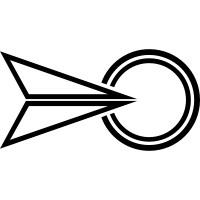

In [23]:
array_to_img(train_images[100])

In [45]:
print(train_y.shape)
print(train_y[100])
unique, counts = np.unique(val_y, return_counts=True)
dict(zip(unique, counts))

(1400, 1)
[0.]


{0.0: 200, 1.0: 200}

## Rough Model

In [87]:
# Return a new model with the given activation
def get_model(act_function):
    model = models.Sequential()
    model.add(layers.Conv2D(1, (3, 3), activation=act_function,
                        input_shape=(200 ,200,  4)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    
    model.add(Dense(4, input_shape=(160000,), activation=act_function))
    model.add(Dense(1, activation='sigmoid'))

    
    model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    return model

In [88]:
#Activation fuctions to try out
activations = ['relu']
#                , 'sigmoid', 'tanh']

#Dictuionary to store results
activation_results = {}

# checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
#                                monitor = 'val_accuracy',
#                                verbose=1, 
#                                save_best_only=True)

for funct in activations:
    model = get_model(act_function=funct)
    model.summary()
    history = model.fit(train_images, train_y, 
#                       callbacks=[checkpointer],
                        validation_data=(val_images, val_y), 
                        epochs=20)
    activation_results[funct] = history

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 198, 198, 1)       37        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 99, 99, 1)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 9801)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 39208     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 39,250
Trainable params: 39,250
Non-trainable params: 0
_________________________________________________________________
Train on 1400 samples, validate on 400 samples
Epoch 1/20
1400/1400 [==============================] - 2s 1ms/step 

In [76]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [77]:
# print('tanh returned a max validation accuracy of', max(activation_results['tanh'].history['val_accuracy']), 'and a training data accuracy of', max(activation_results['tanh'].history['accuracy']) )
print('relu returned a max validation accuracy of', max(activation_results['relu'].history['val_accuracy']), 'and a training data accuracy of', max(activation_results['relu'].history['accuracy']) )
# print('sigmoid returned a max validation accuracy of', max(activation_results['sigmoid'].history['val_accuracy']), 'and a training data accuracy of', max(activation_results['sigmoid'].history['accuracy']) )

relu returned a max validation accuracy of 0.5 and a training data accuracy of 0.50285715


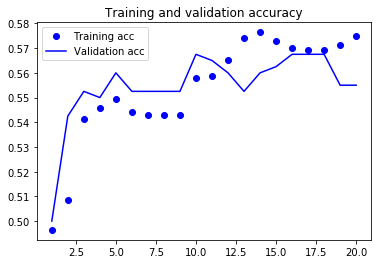

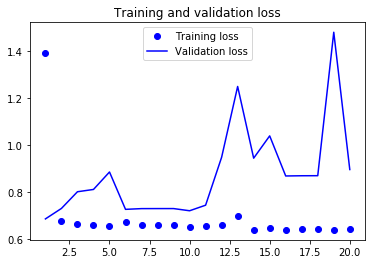

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [61]:
x = np.array(test_images[0:10])
test_datagen = ImageDataGenerator(rescale=1./255)

[[0.403196]]
[[0.3902906]]
[[0.41824126]]
[[0.40872633]]
[[0.37792528]]
[[0.39423358]]
[[0.42395687]]
[[0.4122803]]
[[0.4094464]]
[[0.3961685]]


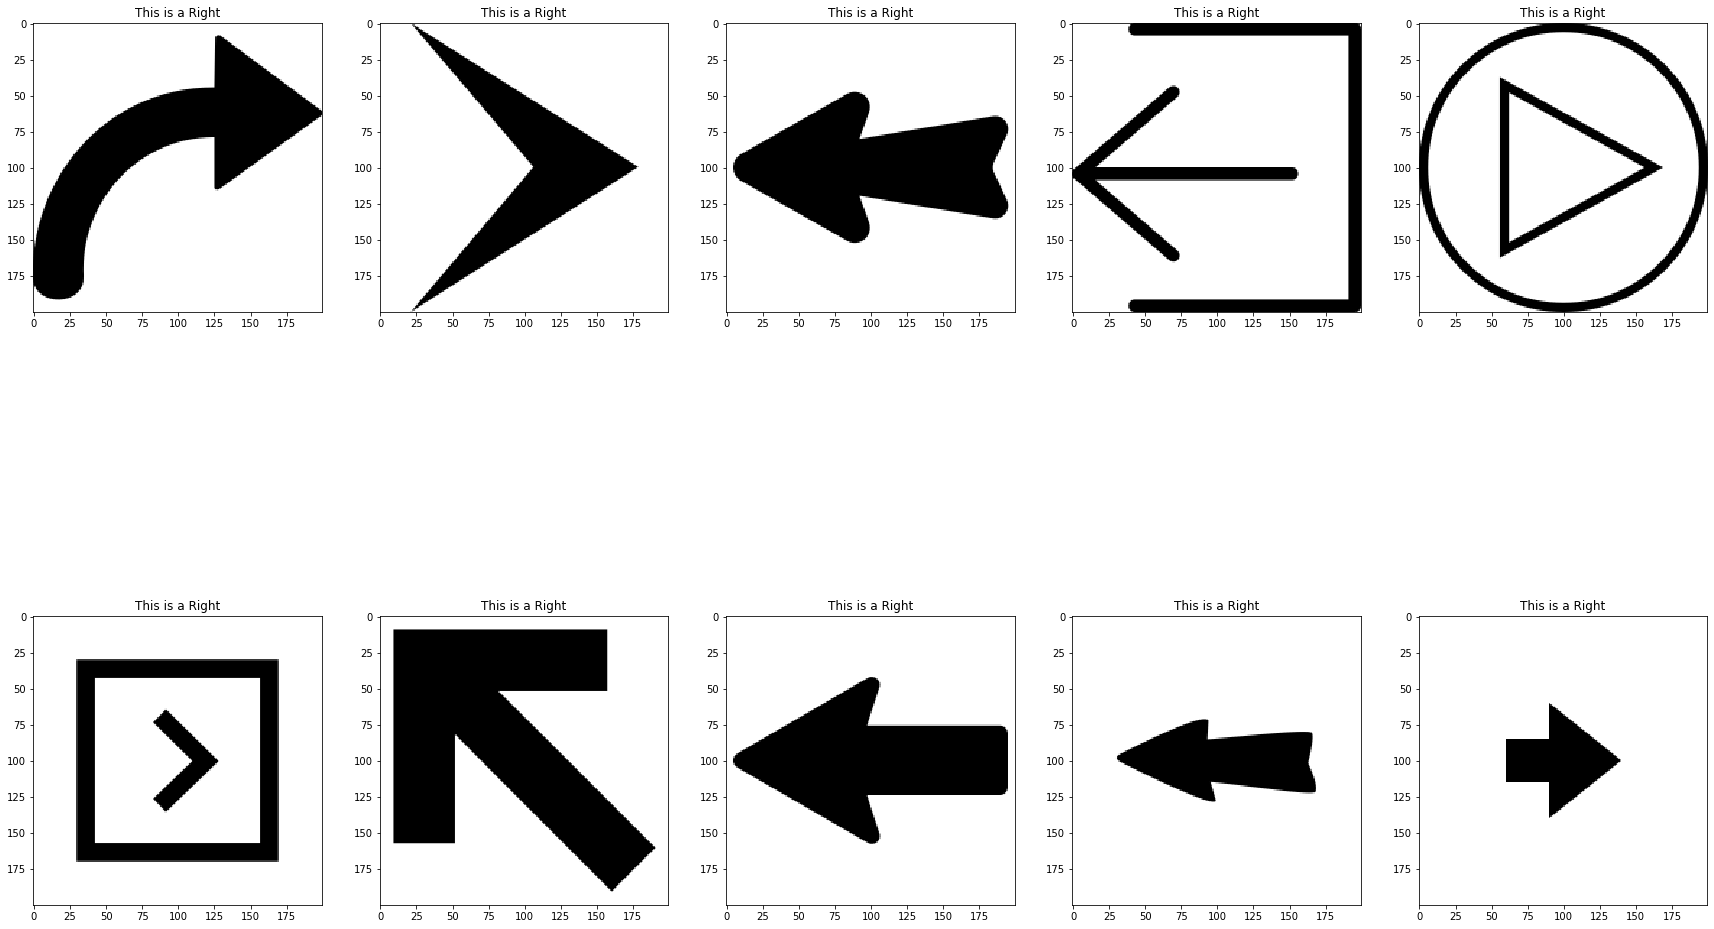

In [64]:
i = 0
columns = 5
text_labels = []
plt.figure(figsize = (30,20))
for image in test_datagen.flow(x, batch_size=1):
    pred = 0
    pred = model.predict(image)
    model.predict_classes
    print(pred)
    if pred > 0.5:
        text_labels.append('Left')
    else:
        text_labels.append('Right')
    plt.subplot(5/columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(image[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

## Second Rough Model from Learn.Co Material

In [ ]:
test_y = np.reshape(test_labels[:,0], (280,1))
val_y = np.reshape(val_labels[:,0], (400,1))

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200 ,200,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['acc'])

In [ ]:
history = model.fit(train_images,
                    train_y,
                    epochs=200,
                    batch_size=32,
                    validation_data=(val_images, val_y))

In [ ]:
results_train = model.evaluate(train_images, train_y)

In [ ]:
results_test = model.evaluate(test_images, test_y)

In [ ]:
results_train

In [ ]:
results_test

## A simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers from Keras blog "building powerful image classification models using very little data"

In [ ]:



# dimensions of our images.
img_width, img_height = 200, 200

train_data_dir = 'split/train'
validation_data_dir = 'split/validation'
nb_train_samples = 700
nb_validation_samples = 200
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

## Buddy's Neural Network 

In [ ]:
# dimensions of our images.
img_width, img_height = 200, 200

train_data_dir = 'split/train'
validation_data_dir = 'split/validation'
train_samples = 700
validation_samples = 200
epochs = 500
batch_size = 50

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [ ]:
array_to_img(train_images[12])